In [32]:
from charge_dataset import ChargeDataset
import random
from tokenizer import Tokenizer
import torch
from torch.utils.data import DataLoader
from utils import  *
from model import *
from train import train
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

In [33]:
TEST_SET = False
CONF = load_conf()
CONF["special_tokens"] = {
    # CONF["unk_token"]: 1,
    CONF["pad_token"]: 0,
    # CONF["sos_token"]: 12,
    # CONF["eos_token"]: 13,
}


# set seed
set_seed(CONF['seed'])

def collate_fn(batch):
    PAD_IDX = CONF["special_tokens"][CONF["pad_token"]]
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

# get device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

# load templates
train_templates, val_templates, test_templates = load_templates(path="Charge.txt", sos_eos=True,
                                                                split=0.2, test_set=TEST_SET)

67 total templates
54 training templates
13 validation templates
0 test templates


In [34]:
with open(os.path.join("data", 'train_data.pickle'), "rb") as f:
    train_templates = pickle.load(f)
with open(os.path.join("data", 'validation_data.pickle'), "rb") as f:
    val_templates = pickle.load(f)
if TEST_SET:
    with open(os.path.join("data", "test_data.pickle"), "rb") as f:
        test_templates = pickle.load(f)

In [35]:
for t in val_templates[:2]:
    print(t)

['شارژ', '{amount}', '{unit}', '{charge_type}', '{operator}', '{for_{me}}', '{verb}']
['{for}', '{device}', '{me}', '{from}', '{account}', '{bnumber}', 'شارژ', '{amount}', '{unit}', '{operator}', '{verb}']


In [36]:

# Create Tokenizers
x_tokenizer = Tokenizer(num_words=CONF["num_words"], max_seq_len=CONF["max_length"],
                        for_sentence=True)
y_tokenizer = Tokenizer(num_words=CONF["num_words"], max_seq_len=CONF["max_length"],
                        for_sentence=False, sos_eos=True)

# Create Datasets
train_dataset = ChargeDataset(train_templates, x_tokenizer, y_tokenizer, CONF["num_train_data"], DEVICE)
train_dataset.train = True
valid_dataset = ChargeDataset(val_templates, x_tokenizer, y_tokenizer, CONF["num_val_data"], DEVICE)
valid_dataset.train = False
if TEST_SET:
    test_dataset = ChargeDataset(test_templates, x_tokenizer, y_tokenizer, CONF["num_val_data"], DEVICE)
    test_dataset.train = False

# get data loaders
train_dataloader = DataLoader(train_dataset, batch_size=CONF['batch_size'],
                              shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=CONF['batch_size'],
                              shuffle=True, collate_fn=collate_fn)
if TEST_SET:
    test_dataloader = DataLoader(test_dataset, batch_size=CONF['batch_size'],
                                 shuffle=True, collate_fn=collate_fn)
# create model
encoder = Encoder(input_dim = CONF["num_words"]+50,
                  emb_dim = CONF['embed_size'],
                  hid_dim = CONF['hidden_size'],
                  n_layers = CONF['encoder_layers'],
                  kernel_size = CONF['kernel_size'],
                  dropout = CONF['dropout'],
                  device = DEVICE,
                  max_length=CONF['max_length'],
                  )

decoder = Decoder(output_dim = CONF["num_words"]+50,
                  emb_dim = CONF['embed_size'],
                  hid_dim = CONF['hidden_size'],
                  n_layers = CONF['decoder_layers'],
                  kernel_size = CONF['kernel_size'],
                  dropout = CONF['dropout'],
                  tgt_pad_idx = CONF["special_tokens"][CONF['pad_token']],
                  device = DEVICE,
                  max_length=CONF['max_length'],
                  )

convs2s = Seq2Seq(encoder, decoder, device = DEVICE,)
optimizer = torch.optim.Adam(convs2s.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index = CONF["special_tokens"][CONF['pad_token']]).to(DEVICE)
# criterion = torch.nn.CrossEntropyLoss().to(DEVICE)

In [37]:
# train
train(  convs2s,
        criterion,
        train_dataloader,
        valid_dataloader,
        optimizer,
        CONF["epochs"],
        CONF["clip"],
        )


with open(os.path.join("checkpoint", 'x_tokenizer.pickle'), 'wb') as handle:
    pickle.dump(x_tokenizer, handle)
with open(os.path.join("checkpoint", 'y_tokenizer.pickle'), 'wb') as handle:
    pickle.dump(y_tokenizer, handle)

# chkpoint = torch.load(os.path.join("checkpoint", 'bestmodel.pt'))
convs2s.load_state_dict(load_model())

Evaluating: 100%|██████████| 157/157 [00:08<00:00, 19.43it/s]


Epoch: 01 | Time: 0m 41s
	Train Loss: 0.932 | Train PPL:   2.539
	 Val. Loss: 1.080 |  Val. PPL:   2.945


Evaluating: 100%|██████████| 157/157 [00:11<00:00, 14.21it/s]


Epoch: 02 | Time: 0m 58s
	Train Loss: 0.731 | Train PPL:   2.078
	 Val. Loss: 1.079 |  Val. PPL:   2.940


Evaluating: 100%|██████████| 157/157 [00:15<00:00,  9.85it/s]


Epoch: 03 | Time: 1m 1s
	Train Loss: 0.621 | Train PPL:   1.861
	 Val. Loss: 1.143 |  Val. PPL:   3.137


Evaluating: 100%|██████████| 157/157 [00:20<00:00,  7.76it/s]


Epoch: 04 | Time: 1m 7s
	Train Loss: 0.601 | Train PPL:   1.824
	 Val. Loss: 1.036 |  Val. PPL:   2.817


Evaluating: 100%|██████████| 157/157 [00:13<00:00, 11.62it/s]

Epoch: 05 | Time: 1m 3s
	Train Loss: 0.515 | Train PPL:   1.674
	 Val. Loss: 1.056 |  Val. PPL:   2.874


In [38]:
convs2s.load_state_dict(load_model())

<All keys matched successfully>

In [39]:
def find_slots_from(sentence, model, x_tokenizer, y_tokenizer, device, max_len=CONF["max_length"]):
    model.eval()
    sentence = sentence.strip().split(" ")
    sentence = ["<sos>"] + sentence + ["<eos>"]
    src_indexes = x_tokenizer.words_to_seq(sentence)
    print("source lenght : ", len(src_indexes), src_indexes)
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)
    trg_indexes = [y_tokenizer.word_to_index["<sos>"]]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        # print("trg_tensor", trg_tensor.size())
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        # print("output", output.size())
        # print("output.argmax(2)", output.argmax(2).size())
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        print("کلمه: ", x_tokenizer.seq_to_words([src_indexes[i]]), "اسلات: ", y_tokenizer.seq_to_words([pred_token]))

        if pred_token == y_tokenizer.word_to_index["<eos>"]:
            break
    trg_tokens = y_tokenizer.seq_to_words(trg_indexes)
    return trg_tokens[1:], attention

In [40]:
def display_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(8,8))
    ssentence = sentence.strip().split(" ")
    nattention = attention.squeeze(0).cpu().detach().numpy()
    cax = ax.matshow(nattention, cmap='bone')
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t for t in ssentence]+['<eos>'],
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [41]:
sentence = "شارژ شگفت انگیز ایرنسل 50 هزار تومنی"
translation, attention = find_slots_from(sentence, convs2s, x_tokenizer, y_tokenizer, DEVICE)
print(f'predicted trg = {translation}')
# display_attention(sentence, translation, attention)

source lenght :  45 [3, 62, 65, 6, 1, 1, 97, 37, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
کلمه:  ['<sos>'] اسلات:  ['charge_type']
کلمه:  ['شارژ'] اسلات:  ['charge_type_post']
کلمه:  ['شگفت'] اسلات:  ['operator']
کلمه:  ['انگیز'] اسلات:  ['OOV']
کلمه:  ['OOV'] اسلات:  ['OOV']
کلمه:  ['OOV'] اسلات:  ['amount']
کلمه:  ['هزار'] اسلات:  ['unit']
کلمه:  ['تومنی'] اسلات:  ['OOV']
کلمه:  ['<eos>'] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['bnumber']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['bnumber']
کلمه:  [] اسلات:  ['OOV']
کلمه:  [] اسلات:  ['charge_type']
کلمه:  [] اسلات:  ['charge_type_post']
کلمه:  [] اسلات:  ['ope

In [20]:
x_tokenizer.index_to_word

{2: '<eos>',
 3: '<sos>',
 4: 'آنلاین',
 5: 'از',
 6: 'انگیز',
 7: 'اول',
 8: 'ایرانسل',
 9: 'اینترنت',
 10: 'با',
 11: 'بخر',
 12: 'بخرید',
 13: 'بخرین',
 14: 'برا',
 15: 'برام',
 16: 'برای',
 17: 'برایم',
 18: 'بریز',
 19: 'بریزید',
 20: 'بریزین',
 21: 'بنده',
 22: 'به',
 23: 'بوسیله',
 24: 'بچت',
 25: 'بکن',
 26: 'بکنید',
 27: 'بکنین',
 28: 'بگیر',
 29: 'بگیرید',
 30: 'بگیرین',
 31: 'تلفن',
 32: 'تو',
 33: 'توسط',
 34: 'تومان',
 35: 'تومانی',
 36: 'تومن',
 37: 'تومنی',
 38: 'جان',
 39: 'جون',
 40: 'حساب',
 41: 'خدا',
 42: 'خری',
 43: 'خرید',
 44: 'خرین',
 45: 'خط',
 46: 'خلیج',
 47: 'خواستم',
 48: 'خوام',
 49: 'خواهش',
 50: 'خواهشا',
 51: 'خواهشمندم',
 52: 'خودم',
 53: 'خوم',
 54: 'دیت',
 55: 'رایتل',
 56: 'رو',
 57: 'ریال',
 58: 'ریالی',
 59: 'سی',
 60: 'سیم',
 61: 'شاتل',
 62: 'شارژ',
 63: 'شم',
 64: 'شماره',
 65: 'شگفت',
 66: 'فارس',
 67: 'لطفا',
 68: 'م',
 69: 'مادرت',
 70: 'مبلغ',
 71: 'مخاطب',
 72: 'مخاطبین',
 73: 'مخاطبینم',
 74: 'معمولی',
 75: 'ممنون',
 76: 'من',
 77: 'مو',


In [33]:
sentence = "عشقم واسم یه شارژ 5 تومنی اینترنت ایرانسل میگیری برام فدات شم"
translation, attention = find_slots_from(sentence, convs2s, x_tokenizer, y_tokenizer, DEVICE)
print(f'predicted trg = {translation}')
# display_attention(sentence, translation, attention)

trg_tensor torch.Size([1, 1])
output torch.Size([1, 1, 300])
output.argmax(2) torch.Size([1, 1])
trg_tensor torch.Size([1, 2])
output torch.Size([1, 2, 300])
output.argmax(2) torch.Size([1, 2])
trg_tensor torch.Size([1, 3])
output torch.Size([1, 3, 300])
output.argmax(2) torch.Size([1, 3])
trg_tensor torch.Size([1, 4])
output torch.Size([1, 4, 300])
output.argmax(2) torch.Size([1, 4])
trg_tensor torch.Size([1, 5])
output torch.Size([1, 5, 300])
output.argmax(2) torch.Size([1, 5])
trg_tensor torch.Size([1, 6])
output torch.Size([1, 6, 300])
output.argmax(2) torch.Size([1, 6])
trg_tensor torch.Size([1, 7])
output torch.Size([1, 7, 300])
output.argmax(2) torch.Size([1, 7])
trg_tensor torch.Size([1, 8])
output torch.Size([1, 8, 300])
output.argmax(2) torch.Size([1, 8])
trg_tensor torch.Size([1, 9])
output torch.Size([1, 9, 300])
output.argmax(2) torch.Size([1, 9])
trg_tensor torch.Size([1, 10])
output torch.Size([1, 10, 300])
output.argmax(2) torch.Size([1, 10])
trg_tensor torch.Size([1, 1

In [1]:
len(sentence.split(" "))

NameError: name 'sentence' is not defined

In [8]:

attention.squeeze(0).cpu().detach().numpy()


(11, 9)

C:\Users\Atlas\AppData\Local\Temp\ipykernel_11228\1428909718.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t for t in ssentence]+['<eos>'],
C:\Users\Atlas\AppData\Local\Temp\ipykernel_11228\1428909718.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


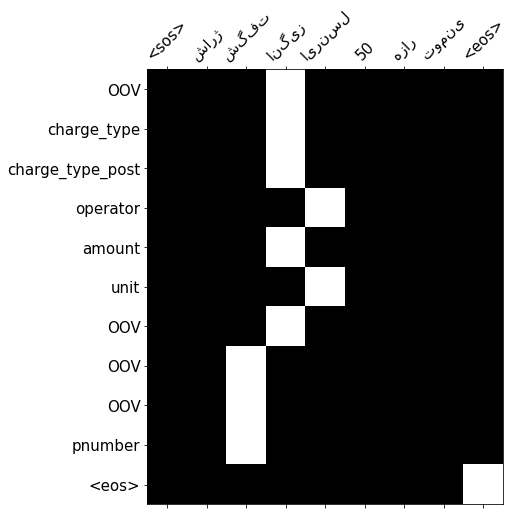

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
ssentence = sentence.strip().split(" ")
nattention = attention.squeeze(0).cpu().detach().numpy()
cax = ax.matshow(nattention, cmap='bone')
ax.tick_params(labelsize=15)
ax.set_xticklabels(['']+['<sos>']+[t for t in ssentence]+['<eos>'],
                   rotation=45)
ax.set_yticklabels(['']+translation)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
plt.close()